In [1]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


!kaggle datasets download -d soumikrakshit/lol-dataset

import zipfile
zip_ref = zipfile.ZipFile('/content/lol-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/dark-face-dataset
License(s): unknown
100% 4.07G/4.08G [00:59<00:00, 27.8MB/s]
100% 4.08G/4.08G [00:59<00:00, 73.7MB/s]


Epoch 1/10
485/485 [==============================] - 10s 9ms/step - loss: 0.1553
Epoch 2/10
485/485 [==============================] - 4s 9ms/step - loss: 0.1337
Epoch 3/10
485/485 [==============================] - 6s 12ms/step - loss: 0.1286
Epoch 4/10
485/485 [==============================] - 4s 9ms/step - loss: 0.1259
Epoch 5/10
485/485 [==============================] - 4s 8ms/step - loss: 0.1241
Epoch 6/10
485/485 [==============================] - 5s 10ms/step - loss: 0.1214
Epoch 7/10
485/485 [==============================] - 4s 9ms/step - loss: 0.1229
Epoch 8/10
485/485 [==============================] - 5s 11ms/step - loss: 0.1197
Epoch 9/10
485/485 [==============================] - 5s 10ms/step - loss: 0.1190
Epoch 10/10
485/485 [==============================] - 4s 8ms/step - loss: 0.1189
Epoch 1/10
485/485 [==============================] - 10s 10ms/step - loss: 0.1504
Epoch 2/10
485/485 [==============================] - 4s 9ms/step - loss: 0.1382
Epoch 3/10
485/485 [

16/16 [==============================] - 0s 17ms/step
Epoch 1/5
485/485 [==============================] - 4s 9ms/step - loss: 0.1533
Epoch 2/5
485/485 [==============================] - 5s 10ms/step - loss: 0.1341
Epoch 3/5
485/485 [==============================] - 5s 10ms/step - loss: 0.1256
Epoch 4/5
485/485 [==============================] - 5s 11ms/step - loss: 0.1256
Epoch 5/5
16/16 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 188ms/step
Average PSNR after Unprocess step: 10.90
Average PSNR after Enhance step: 16.46
Average PSNR after Process step: 8.55


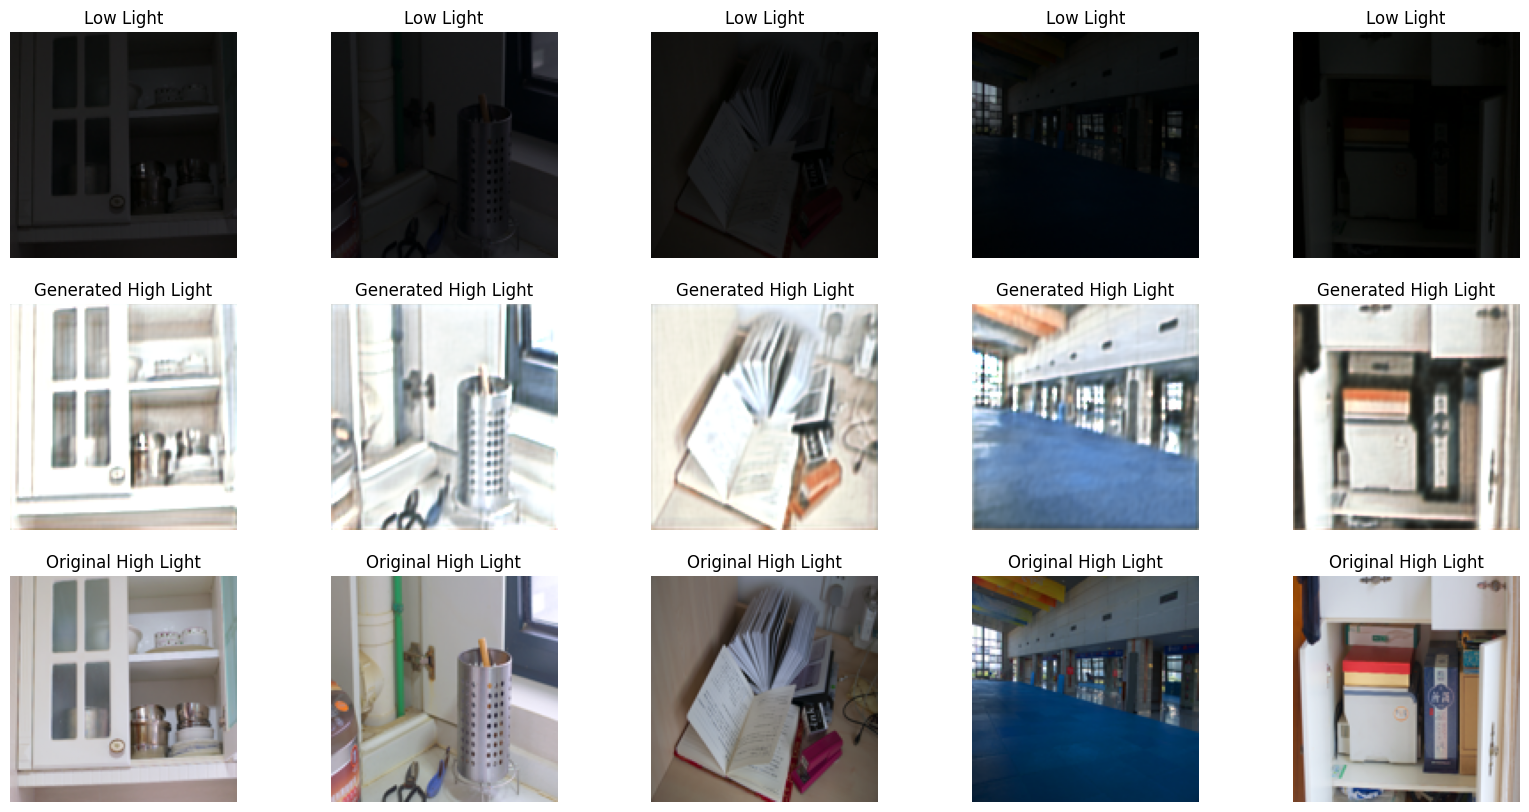

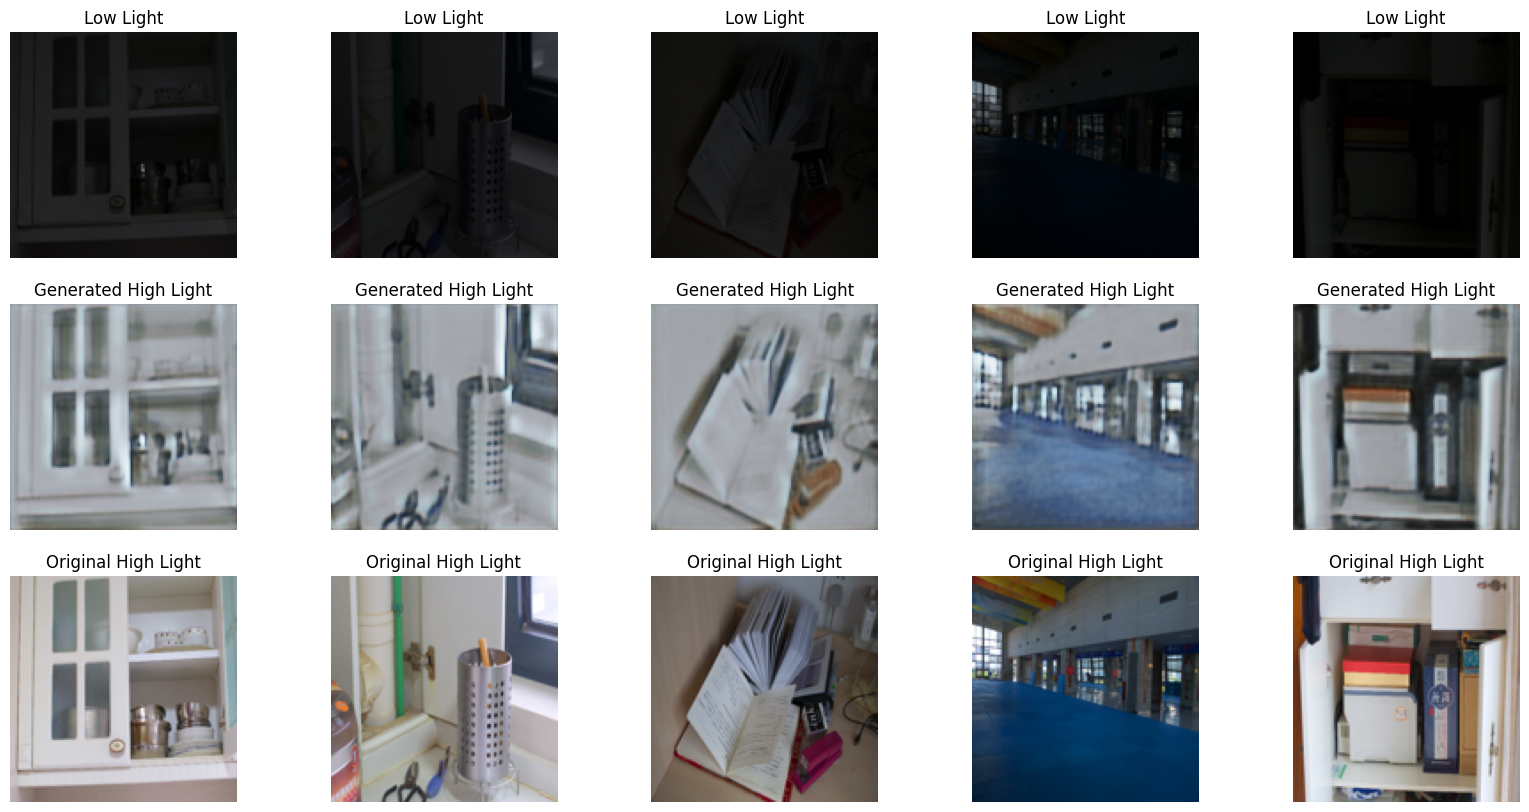

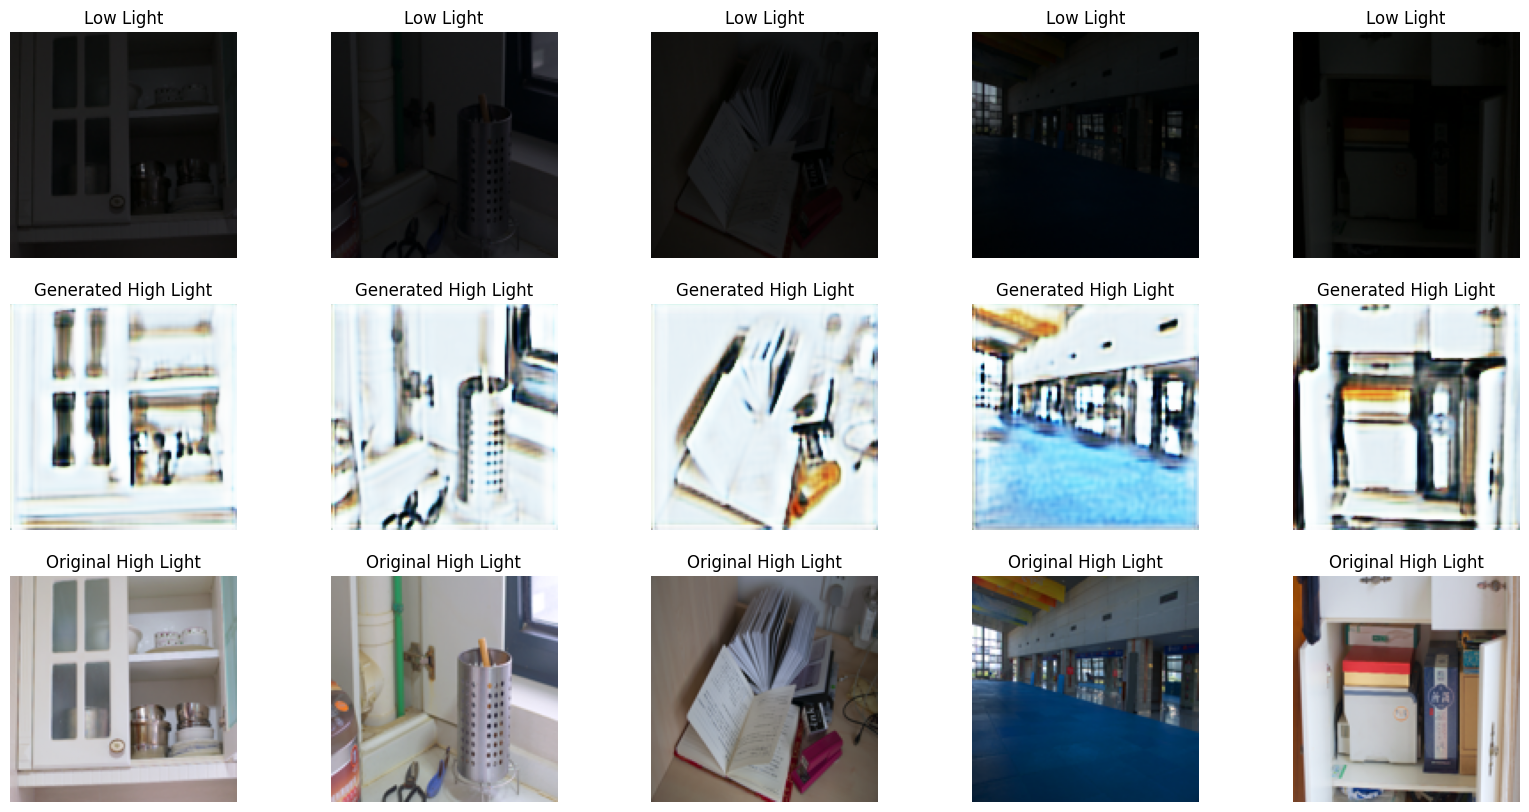

In [ ]:
import os
import zipfile
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr
from keras.preprocessing.image import save_img
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Down-sampling
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Up-sampling
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

def load_images(image_paths, target_size=(256, 256)):
    images = []
    for img_path in image_paths:
        img = Image.open(img_path).resize(target_size)
        img = np.array(img) / 255.0
        images.append(img)
    return np.array(images)

def calculate_psnr(original, generated):
    psnr_scores = []
    for i in range(len(original)):
        score = psnr(original[i], generated[i], data_range=1.0)
        psnr_scores.append(score)
    return np.mean(psnr_scores)

def display_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))
    fig.suptitle(title, fontsize=20)
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

def evaluate_model(model, low_images, high_images):
    predictions = model.predict(low_images)
    average_psnr = calculate_psnr(high_images, predictions)
    return predictions, average_psnr

def display_results(low_images, high_images, generated_images, num_images=5):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(low_images[i])
        plt.title("Low Light")
        plt.axis("off")

        ax = plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(generated_images[i])
        plt.title("Generated High Light")
        plt.axis("off")

        ax = plt.subplot(3, num_images, 2*num_images + i + 1)
        plt.imshow(high_images[i])
        plt.title("Original High Light")
        plt.axis("off")
    plt.show()

train_low_paths = glob('lol_dataset/our485/low/*.png')
train_high_paths = glob('lol_dataset/our485/high/*.png')
test_low_paths = glob('lol_dataset/eval15/low/*.png')
test_high_paths = glob('lol_dataset/eval15/high/*.png')

train_low_images = load_images(train_low_paths)
train_high_images = load_images(train_high_paths)
test_low_images = load_images(test_low_paths)
test_high_images = load_images(test_high_paths)

unprocess_model = unet()
enhance_model = unet()
process_model = unet()

# Compile models
unprocess_model.compile(optimizer=Adam(lr=1e-4), loss='mae')
enhance_model.compile(optimizer=Adam(lr=1e-4), loss='mae')
process_model.compile(optimizer=Adam(lr=1e-4), loss='mae')

# Training each sub-network
unprocess_model.fit(train_low_images, train_high_images, epochs=100, batch_size=1, verbose=1)
enhance_model.fit(train_low_images, train_high_images, epochs=100, batch_size=1, verbose=1)
process_model.fit(train_low_images, train_high_images, epochs=100, batch_size=1, verbose=1)

# Joint Training
train_high_linear = unprocess_model.predict(train_low_images) * 1.75
enhance_model.fit(train_high_linear, train_high_images, epochs=50, batch_size=1, verbose=1)
final_output = process_model.predict(enhance_model.predict(train_high_linear))

# Save models
unprocess_model.save('unprocess_model.h5')
enhance_model.save('enhance_model.h5')
process_model.save('process_model.h5')

# Load models
unprocess_model = tf.keras.models.load_model('unprocess_model.h5')
enhance_model = tf.keras.models.load_model('enhance_model.h5')
process_model = tf.keras.models.load_model('process_model.h5')

# Predict images at each step
brightened_linear = unprocess_model.predict(test_low_images) * 1.75  # Example exposure time ratio
enhanced_images = enhance_model.predict(brightened_linear)
high_quality_images = process_model.predict(enhanced_images)

# Normalize results
brightened_linear = np.clip(brightened_linear, 0, 1)
enhanced_images = np.clip(enhanced_images, 0, 1)
high_quality_images = np.clip(high_quality_images, 0, 1)

# Calculate PSNR
psnr_unprocess = calculate_psnr(test_high_images, brightened_linear)
psnr_enhance = calculate_psnr(test_high_images, enhanced_images)
psnr_process = calculate_psnr(test_high_images, high_quality_images)

print(f'Average PSNR after Unprocess step: {psnr_unprocess:.2f}')
print(f'Average PSNR after Enhance step: {psnr_enhance:.2f}')
print(f'Average PSNR after Process step: {psnr_process:.2f}')

# Save the generated images
output_dir = './test/predicted/'
os.makedirs(output_dir, exist_ok=True)

for i, img in enumerate(high_quality_images):
    save_img(os.path.join(output_dir, f'predicted_{i}.png'), img)

# Display some results
display_results(test_low_images, test_high_images, brightened_linear)
display_results(test_low_images, test_high_images, enhanced_images)
display_results(test_low_images, test_high_images, high_quality_images)


In [ ]:
psnr_total = calculate_psnr(test_high_images, brightened_linear)